# Imports

In [1]:
import os
import re

import emoji
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', 100)

# Read Data

In [2]:
df_full = pd.read_csv('./data/sampled_data.csv')

# Feature Engineering
Adding fulltext and engagement_score

In [3]:
def concatenate_fields(df, field_1='title', field_2='selftext'):
    df['fulltext'] = df[field_1] + ' ' + df[field_2]
    return df

df_full = concatenate_fields(df_full)

In [4]:
def add_engagement_score(df_orig):
    df = df_orig.copy()
    
    df['all_votes'] = df['score'] / df['upvote_ratio']
    df['engagement_score'] = df['all_votes'] + df['num_comments'] + df['num_crossposts']
    
    return df
    
df_full = add_engagement_score(df_full)

# Split Data

In [5]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink',
           'score', 'fulltext',
        ]]

    Y_full = df_full['engagement_score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0], random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [6]:
df = pd.concat((X_train, y_train), axis=1)

# Examine Training Data for Cleaning

In [7]:
df.shape

(29630, 26)

In [8]:
df.isna().sum()

id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          9860
upvote_ratio                0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    0
thumbnail                   0
shortlink                   0
score                       0
fulltext                    0
engagement_score            0
dtype: int64

In [9]:
df.shape

(29630, 26)

In [10]:
df.dropna(subset='score').shape

(29630, 26)

### Dropping Null fulltext values

In [11]:
print(df.shape)
df = df.dropna(subset='fulltext')
print(df.shape)

(29630, 26)
(29630, 26)


### Dropping Null selftext values

In [12]:
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)

(29630, 26)
(29630, 26)


### Filling NA's for link_flair_text

In [13]:
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score,fulltext,engagement_score
9434,py43mo,lilsuperhippo,2021-09-29 20:36:03,2021-09-30 03:25:28,2021-09-29 20:39:13,0,0,0,0,0,...,0,0,5,0,Is it legal for employee of company X to receive shares of the company as a gift / donation fro...,self,https://redd.it/py43mo,4,can employee of a company receive shares of a company from someone outside? Is it legal for emp...,10.405405
35136,rdinbe,BurnerBurnerBurns20,2021-12-10 21:06:20,2021-12-11 04:37:59,1970-01-01 00:00:00,0,0,0,0,0,...,0,0,39,0,"Which of these do people see not doing much next year?\n\nAmazon, Netflix, Blackstone, Google, o...",self,https://redd.it/rdinbe,4,"Between Amazon, Netflix, BX, Google, and Facebook which do you see underperforming or falling mo...",45.666667


In [14]:
df.describe()

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score,engagement_score
count,29630.0,29630.0,29630.000000,29630.000000,29630.0,29630.0,29630.0,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000
mean,0.0,0.0,0.001316,0.005872,0.0,1.0,0.0,0.018360,0.778659,0.022207,0.840094,62.010597,0.065913,93.361120,163.732477
std,0.0,0.0,0.036257,0.076408,0.0,0.0,0.0,0.134251,0.198419,0.328503,20.738847,1087.322230,0.586857,1499.422359,2319.073771
min,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.670000,0.000000,0.000000,3.000000,0.000000,1.000000,7.000000
50%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.820000,0.000000,0.000000,8.000000,0.000000,5.000000,16.451159
75%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.950000,0.000000,0.000000,21.000000,0.000000,18.000000,43.857781
max,0.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1.000000,1.000000,24.000000,2548.000000,82334.000000,57.000000,154745.000000,201351.786517


Remove the "Unnamed: 0" field

In [15]:
df.iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score,fulltext,engagement_score
41030,l8x14u,finance_student,2021-01-30 22:07:28,2021-02-05 15:50:55,1970-01-01 00:00:00,0,0,0,0,0,...,0,0,12,0,"With the influx of new users and feedback from existing users, we have used this opportunity to ...",self,https://redd.it/l8x14u,15,"Subreddit Rules UPDATE With the influx of new users and feedback from existing users, we have us...",28.483516
19474,oltz3v,SavannahSmiles_,2021-07-17 00:44:19,2021-07-17 07:09:01,1970-01-01 00:00:00,0,0,0,0,0,...,0,0,4,0,[Square is building a decentralized finance business using bitcoin (cnbc.com)](https://www.cnbc...,self,https://redd.it/oltz3v,7,Square is building a decentralized finance business using bitcoin [Square is building a decentr...,12.536585


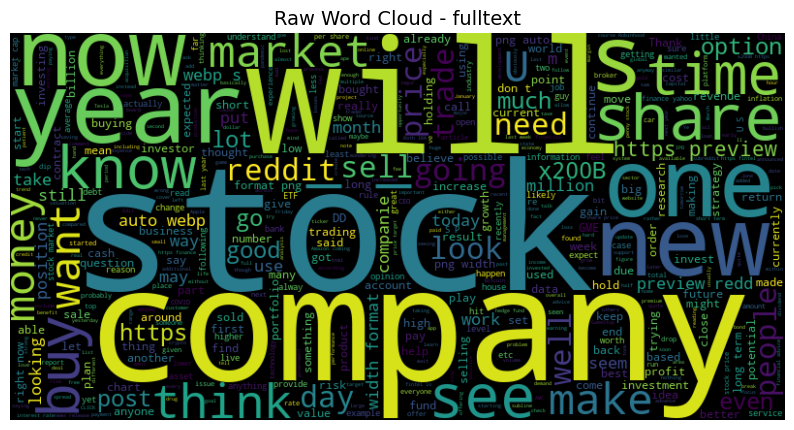

In [16]:
plt.figure(figsize=(10, 10))
words = " ".join(df['fulltext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud - fulltext', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Reviewing unexpected terms, such as https, webp, pgn.

Where are these words coming from?

In [17]:
search_terms = [r'https', r'webp','png']

The search terms are all part of url's. They will be removed.

In [18]:
df[df['fulltext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['fulltext'].iloc[0]

"Subreddit Rules UPDATE With the influx of new users and feedback from existing users, we have used this opportunity to refresh and update the rules found in the sidebar (or about section of reddit mobile.)\n\nNote: if you're using [old.reddit.com](https://old.reddit.com), the rules will be updated there shortly. This is mostly for the droves of new users now part of the sub. \n\nAny feedback is welcome in this thread regarding the new rules, and we are open to suggestions of new rules you feel will be beneficial to this sub. Feel free to chime in. \n\nCheers!\n\nJack"

In [19]:
df[df['fulltext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['fulltext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

"Subreddit Rules UPDATE With the influx of new users and feedback from existing users, we have used this opportunity to refresh and update the rules found in the sidebar (or about section of reddit mobile.)\n\nNote: if you're using [old.reddit.com](<url>), the rules will be updated there shortly. This is mostly for the droves of new users now part of the sub. \n\nAny feedback is welcome in this thread regarding the new rules, and we are open to suggestions of new rules you feel will be beneficial to this sub. Feel free to chime in. \n\nCheers!\n\nJack"

Remove URL's, and replace with "< url >"

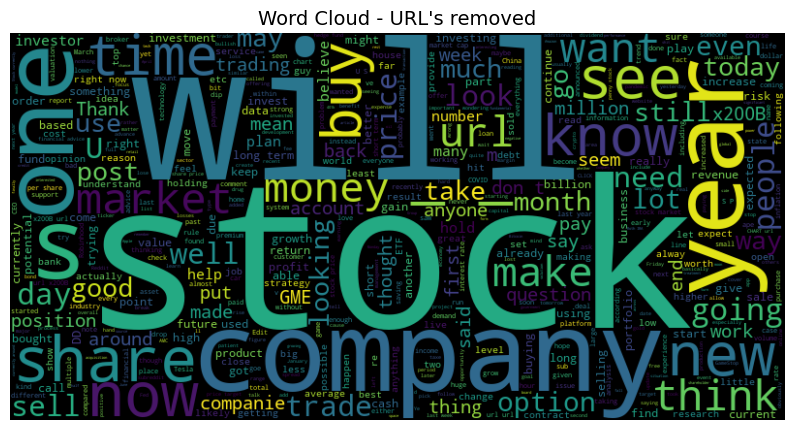

In [20]:
plt.figure(figsize=(10, 10))
words = " ".join( df['fulltext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [21]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['fulltext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['fulltext'].iloc[0][:1000]

'Anyone see the license plate of that Mack Truck? No patience and fear of loss I closed my GA trade at BE. One candle later price dropped like a rock.\n\n&#x200B;\n\n[No patience fear of loss. I closed my trade at break even. one candle later price dropped](https://preview.redd.it/3h1bxjdkn2f71.png?width=1542&format=png&auto=webp&s=abc4daf052e13f143aea5b9f5c6dd7f00cf7f864)\n\nBut I did catch NU. Only for 1.5R priced moved too fast for me to extend my target.\n\n&#x200B;\n\n[NU](https://preview.redd.it/ygxa02j5o2f71.png?width=1542&format=png&auto=webp&s=6881a4b457ecb2d3066927e8f68ccdbc7d2914d1)\n\n&#x200B;\n\n[Live trades](https://preview.redd.it/tea09w37p2f71.jpg?width=1920&format=pjpg&auto=webp&s=7f7e1bed7207200241082920bded06b0406cce11)'

In [22]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['fulltext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0][:1000]

'Anyone see the license plate of that Mack Truck? No patience and fear of loss I closed my GA trade at BE. One candle later price dropped like a rock.\n\n&#;\n\n[No patience fear of loss. I closed my trade at break even. one candle later price dropped](https://preview.redd.it/3h1bxjdkn2f71.png?width=1542&format=png&auto=webp&s=abc4daf052e13f143aea5b9f5c6dd7f00cf7f864)\n\nBut I did catch NU. Only for 1.5R priced moved too fast for me to extend my target.\n\n&#;\n\n[NU](https://preview.redd.it/ygxa02j5o2f71.png?width=1542&format=png&auto=webp&s=6881a4b457ecb2d3066927e8f68ccdbc7d2914d1)\n\n&#;\n\n[Live trades](https://preview.redd.it/tea09w37p2f71.jpg?width=1920&format=pjpg&auto=webp&s=7f7e1bed7207200241082920bded06b0406cce11)'

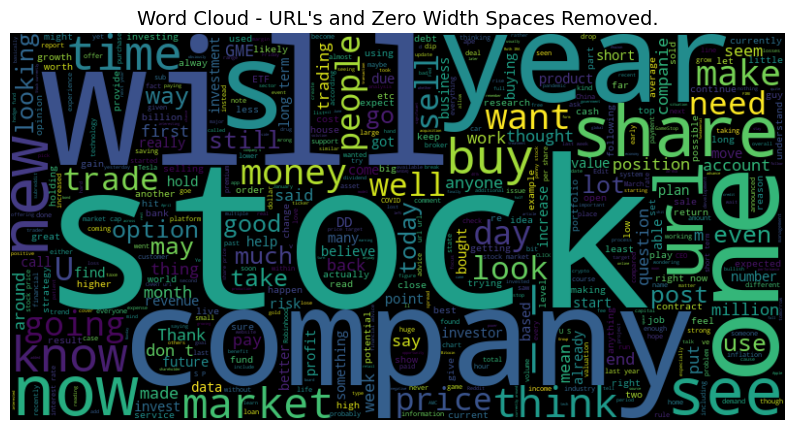

In [23]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['fulltext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and Zero Width Spaces Removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [24]:
df['fulltext'].value_counts().iloc[:5]

fulltext
Daily Discussion Thread Discuss your picks and ideas below. This is also a great place for gain/loss pics. Keep things civil.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

This contains recurring discussion posts and self_text values of '[deleted]' which should be removed.

In [25]:
df.shape, df[df['fulltext']!='[deleted]'].shape

((29630, 26), (29630, 26))

### Discussion Posts

Discussion posts will **not be removed** as many users interact with these posts.

In [26]:
text_frequency = df['fulltext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['fulltext'].tolist()

In [27]:
# Show one discussion post
discussion_posts[0]

'Daily Discussion Thread Discuss your picks and ideas below. This is also a great place for gain/loss pics. Keep things civil.'

# Cleaning Data

### Drop NA's

In [28]:
df = df.dropna(subset='fulltext')

### Fill NA's

In [29]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries

In [30]:
df[df['fulltext']==''].shape

(0, 26)

In [31]:
df[df['selftext']==''].shape

(0, 26)

In [32]:
df = df[df['fulltext']!='[deleted]']
df = df[df['selftext']!='[deleted]']

### Preprocess data and clean data
We must remove excess HTML and other words.

In [33]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [34]:
# def preprocessor(text):
#     try:
#         text = re.sub('<[^>]*>', '', text)
#         emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
#                                text)
#         text = (re.sub('[\W]+', ' ', text.lower()) +
#                 ' '.join(emoticons).replace('-', ''))
#     except Exception as e:
#         print(f'Exception when preprocessing.\n{e}')
#     finally:
#         return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    try:
        text = str(text).lower()
        text = re.sub(r'#(\w+)', r'<\1>', text)
        text = re.sub(r'\n', ' ', text) # Remove /n
        text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
        text = re.sub(r'RT\s+', '', text) # Remove RT
        text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
        text = re.sub('x200B', '', text)
        text = re.sub('<[^>]*>', '', text)

        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                                   text)
        text = (re.sub('[\W]+', ' ', text) + ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

def drop_unnamed_columns(df_orig):
    df = df_orig.copy()
    unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df_full.drop(columns=unnamed_columns)
    return df

In [35]:
df['fulltext'] = df['fulltext'].apply(cleaner)

In [36]:
df['selftext'] = df['selftext'].apply(cleaner)

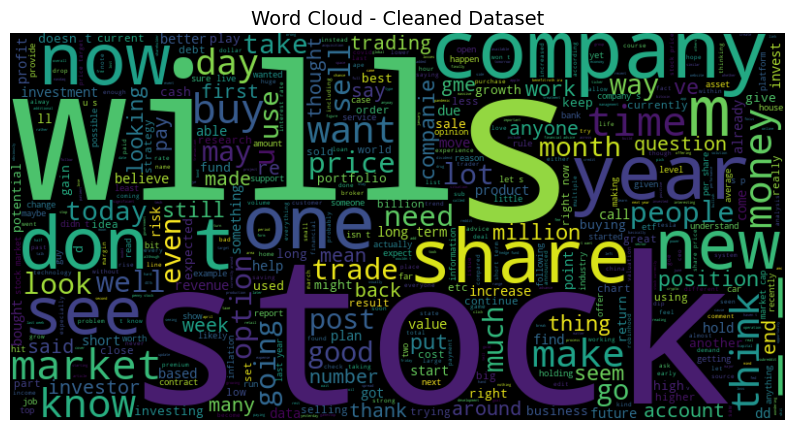

In [37]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['fulltext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

# Standardizing Numeric Fields

### Examine Numeric Fields

In [38]:
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score,engagement_score
41030,0,0,0,0,0,1,0,0,0.91,0,0,12,0,15,28.483516
19474,0,0,0,0,0,1,0,0,0.82,0,0,4,0,7,12.536585
1823,0,0,0,0,0,1,0,0,0.66,0,0,4,0,1,5.515152
3484,0,0,0,0,0,1,0,0,0.43,0,0,3,0,0,3.000000
37319,0,0,0,0,0,1,0,0,0.96,0,1,9,0,89,101.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,0,0,0,0,0,1,0,0,0.81,0,0,4,0,6,11.407407
32511,0,0,0,0,0,1,0,0,0.74,0,0,21,0,7,30.459459
5192,0,0,0,0,0,1,0,0,1.00,0,0,3,0,1,4.000000
12172,0,0,0,0,0,1,0,0,0.88,0,1,2,0,12,15.636364


### Scale Numeric Fields

In [39]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts', 'engagement_score']

non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [40]:
scaler = StandardScaler()

# Scale training data for examination
df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [41]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [42]:
df_std.iloc[1:3]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,thumbnail,shortlink,fulltext,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,engagement_score
1,oltz3v,SavannahSmiles_,2021-07-17 00:44:19,2021-07-17 07:09:01,1970-01-01 00:00:00,0,0,0,0,0,...,self,https://redd.it/oltz3v,square is building a decentralized finance business using bitcoin square is building a decentral...,0.208355,-0.057597,-0.067602,-0.040509,-0.053353,-0.112317,-0.065198
2,m7cbj6,B3lli4l,2021-03-17 22:21:34,2021-03-18 05:11:25,1970-01-01 00:00:00,0,0,0,0,0,...,self,https://redd.it/m7cbj6,issues with charts hey everyone i am experiecing something wierd on my trading sessions the last...,-0.598034,-0.061599,-0.067602,-0.040509,-0.053353,-0.112317,-0.068226


# Full Dataset Cleaning and Training/Validation/Test Assignments

Writes final file for models

## Decisions:
 * Clean NA's
 * Clean selftext data 
    * brackets
    * URL's
 * Empty rows on the "score" column
 * Dot not remove discussion posts.

In [43]:
df_full = df_full.dropna(subset=['fulltext','selftext'])

In [44]:
df_full = df_full.fillna({'link_flair_text':''})

In [45]:
df_full = df_full[df_full['fulltext']!='[deleted]']

In [46]:
df_full = df_full[df_full['selftext']!='[deleted]']

### Clean and Preprocess Data

In [47]:
df_full['fulltext'] = df_full['fulltext'].apply(cleaner)

In [48]:
df_full['selftext'] = df_full['selftext'].apply(cleaner)

### Drop Columns containing "Unnamed"

In [49]:
df_full = drop_unnamed_columns(df_full)

### Drop Empty selftext and fulltext

In [50]:
def drop_empty_column_records(df_orig, column):
    df = df_orig.copy()
    return df[df[column]!='']

In [51]:
df_full = drop_empty_column_records(df_full, 'selftext')
df_full = drop_empty_column_records(df_full, 'fulltext')

### Scale Numeric Fields

In [52]:
def scale_numeric_fields(scaler, df, df_train, scaling_fields):
    non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

    scaler.fit(df_train[scaling_fields].values)
    
    df_scaled_values = scaler.transform(df[scaling_fields].values)
    df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)
    df_scaled = df_scaled.add_suffix('_std', axis=1)

    df_std = pd.concat((df.reset_index(drop=True), df_scaled), axis=1)
    
    return df_std

In [53]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts','engagement_score']

scaler = StandardScaler()

df_full = scale_numeric_fields(scaler, df_full, df, scaling_fields)

In [54]:
df_full.iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,fulltext,all_votes,engagement_score,upvote_ratio_std,score_std,gilded_std,total_awards_received_std,num_comments_std,num_crossposts_std,engagement_score_std
0,l6b7qn,CaptHymanShocked,2021-01-27 18:31:06,2021-02-04 22:09:39,1970-01-01 00:00:00,0,0,0,0,0,...,charles payne hates shorts too he took his glasses off for this one love this guy,11.956522,15.956522,0.712349,-0.054929,-0.067602,-0.040509,-0.053353,-0.112317,-0.063723
1,lfax7f,Mik-Hail-tal,2021-02-08 12:37:24,2021-02-09 00:47:19,1970-01-01 00:00:00,0,0,0,0,0,...,megola inc mgon question blocked stock i ve been holding 9000 shares since 2018 0 0143 recently ...,7.865169,11.865169,0.561151,-0.057597,-0.067602,-0.040509,-0.053353,-0.112317,-0.065487


### Split Data into Train, Validation, Test sets

In [55]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[[
        'id', 'author', 'created', 'retrieved', 'edited',
        'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
        'is_video', 'is_original_content', 'title', 'link_flair_text',
        'upvote_ratio',  'gilded', 'total_awards_received',
        'num_comments', 'num_crossposts', 'selftext', 'selftext',
        'thumbnail', 'shortlink', 'upvote_ratio_std', 'score_std',
        'gilded_std', 'total_awards_received_std', 'num_comments_std',
        'num_crossposts_std','engagement_score_std'
    ]]

    Y_full = df_full['engagement_score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0], random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [56]:
X_train.to_csv('./data/final/X_train.csv', index=False)
y_train.to_csv('./data/final/y_train.csv', index=False)
X_val.to_csv('./data/final/X_val.csv', index=False)
y_val.to_csv('./data/final/y_val.csv', index=False)
X_test.to_csv('./data/final/X_test.csv', index=False)
y_test.to_csv('./data/final/y_test.csv', index=False)